1.

In [7]:
import pandas as pd

# 1. Load data
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')

# 2. Convert time columns to datetime format (optional but recommended)
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# 3. Calculate outbound trips per station
outbound_counts = df.groupby('from_station_id').size().reset_index(name='outbound_trips')

# 4. Calculate inbound trips per station
inbound_counts = df.groupby('to_station_id').size().reset_index(name='inbound_trips')

# 5. Merge inbound and outbound counts
station_counts = pd.merge(outbound_counts, inbound_counts, left_on='from_station_id', right_on='to_station_id', how='outer')

# 6. Fill NaN values with 0 (stations that only have inbound or outbound trips)
station_counts['outbound_trips'] = station_counts['outbound_trips'].fillna(0).astype(int)
station_counts['inbound_trips'] = station_counts['inbound_trips'].fillna(0).astype(int)
station_counts['difference_trips'] = (station_counts['outbound_trips'] - station_counts['inbound_trips']).abs()

# 7. Create a unified station_id column
station_counts['station_id'] = station_counts['from_station_id'].combine_first(station_counts['to_station_id'])

# 8. Select relevant columns
station_counts = station_counts[['station_id', 'outbound_trips', 'inbound_trips','difference_trips']]

# 9. Sort by station_id (optional)
station_counts = station_counts.sort_values(by='station_id').reset_index(drop=True)

outbound = station_counts.sort_values(by='outbound_trips').reset_index(drop=True)

inbound = station_counts.sort_values(by='inbound_trips').reset_index(drop=True)

difference = station_counts.sort_values(by='difference_trips').reset_index(drop=True)

# 10. Display the result
print(station_counts.head())
print(outbound.tail())
print(inbound.tail())
print(difference.tail())

# 11. Save to CSV file (optional)
station_counts.to_csv('station_trip_counts.csv', index=False)


   station_id  outbound_trips  inbound_trips  difference_trips
0         2.0             322            276                46
1         3.0            1339           1134               205
2         4.0             393            411                18
3         5.0             626            723                97
4         6.0             518            393               125
     station_id  outbound_trips  inbound_trips  difference_trips
598       174.0            4571           4875               304
599       195.0            4655           2540              2115
600       192.0            6342           6744               402
601        77.0            6565           6859               294
602        91.0            7699           7699                 0
     station_id  outbound_trips  inbound_trips  difference_trips
598        43.0            3992           4412               420
599       174.0            4571           4875               304
600       192.0            6342      

Outbound Demand Analysis and Forecast:
Station 195 Outbound Demand - ADF Statistic: -1.1934363540632857
Station 195 Outbound Demand - p-value: 0.6764128341860484
Station 195 Outbound Demand - Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -414.378
Date:                Wed, 30 Oct 2024   AIC                            834.756
Time:                        10:17:10   BIC                            842.222
Sample:                    01-01-2019   HQIC                           837.765
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


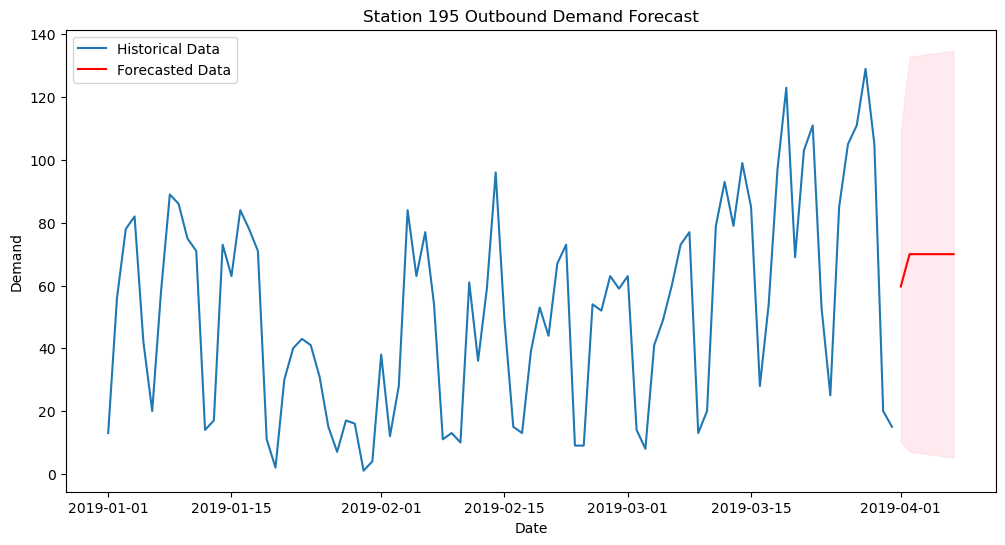

Station 195 Outbound Demand - MAE: 43.5140261489574
Station 195 Outbound Demand - RMSE: 49.13905462921561
Inbound Demand Analysis and Forecast:
Station 195 Inbound Demand - ADF Statistic: -1.2657096147279987
Station 195 Inbound Demand - p-value: 0.6447106142797263
Station 195 Inbound Demand - Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -364.915
Date:                Wed, 30 Oct 2024   AIC                            739.830
Time:                        10:17:11   BIC                            752.273
Sample:                    01-01-2019   HQIC                           744.845
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|  

/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


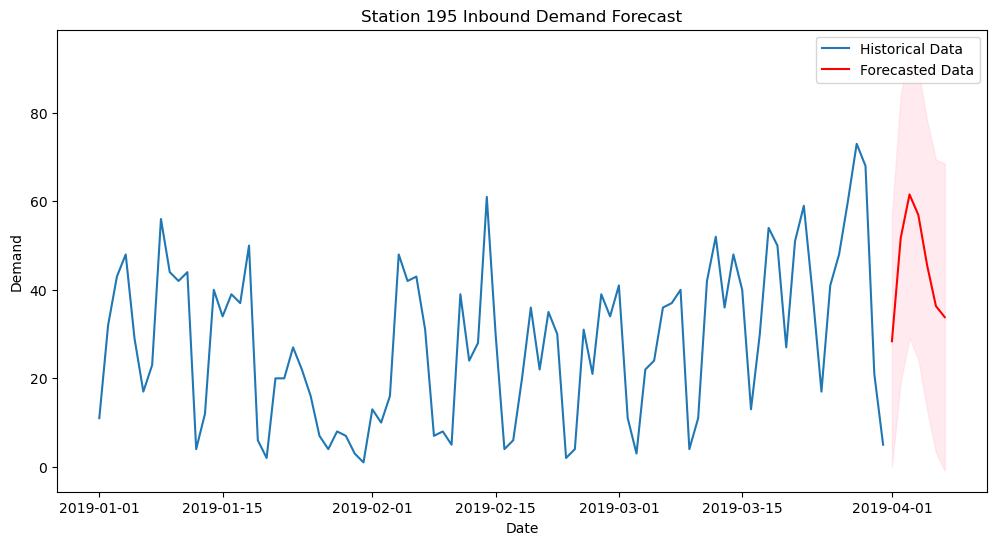

/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Station 195 Inbound Demand - MAE: 21.210895720791513
Station 195 Inbound Demand - RMSE: 24.830421626263416


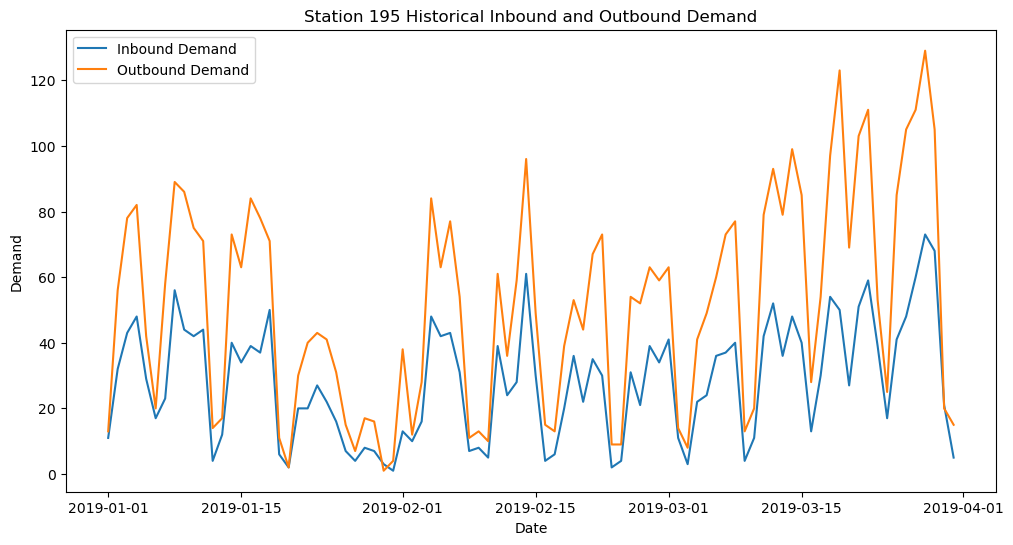

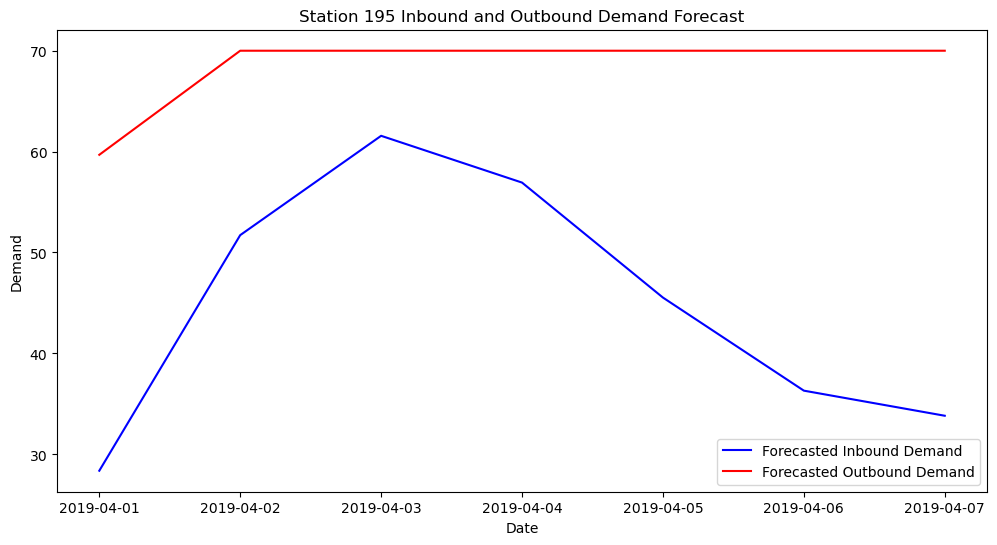

In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Load data
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')

# 2. Convert time format and extract dates
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date

# Choose the station to analyze (e.g., station ID 195)
station_id = 195

# 3. Build outbound time series
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
outbound_series = outbound_data.asfreq('D', fill_value=0)

# 4. Build inbound time series
inbound_data = df[df['to_station_id'] == station_id].groupby('end_date').size()
inbound_series = inbound_data.asfreq('D', fill_value=0)

# 5. Define a function for time series analysis and forecasting
def analyze_and_forecast(time_series, title):
    # Check time series stationarity (ADF test)
    result = adfuller(time_series)
    print(f'{title} - ADF Statistic: {result[0]}')
    print(f'{title} - p-value: {result[1]}')
    # If p-value > 0.05, the series is non-stationary and differencing may be needed

    # Automatically select ARIMA model parameters
    auto_arima_model = auto_arima(time_series, seasonal=False, trace=False)
    print(f'{title} - Best ARIMA Model:')
    print(auto_arima_model.summary())

    # Fit ARIMA model
    order = auto_arima_model.order
    model = ARIMA(time_series, order=order)
    arima_result = model.fit()

    # Forecast future demand (e.g., next 7 days)
    forecast_steps = 7
    forecast = arima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label='Historical Data')
    plt.plot(forecast_series, label='Forecasted Data', color='red')
    plt.fill_between(forecast_series.index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'{title} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

    # Calculate error metrics
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]
    model_train = ARIMA(train, order=order).fit()
    pred_test = model_train.forecast(len(test))
    mae = mean_absolute_error(test, pred_test)
    rmse = np.sqrt(mean_squared_error(test, pred_test))
    print(f'{title} - MAE: {mae}')
    print(f'{title} - RMSE: {rmse}')

    return forecast_series

# 6. Analyze and forecast outbound demand
print('Outbound Demand Analysis and Forecast:')
forecast_outbound = analyze_and_forecast(outbound_series, f'Station {station_id} Outbound Demand')

# 7. Analyze and forecast inbound demand
print('Inbound Demand Analysis and Forecast:')
forecast_inbound = analyze_and_forecast(inbound_series, f'Station {station_id} Inbound Demand')

# 8. Visualize historical inbound and outbound data
plt.figure(figsize=(12, 6))
plt.plot(inbound_series.index, inbound_series, label='Inbound Demand')
plt.plot(outbound_series.index, outbound_series, label='Outbound Demand')
plt.title(f'Station {station_id} Historical Inbound and Outbound Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

# 9. Visualize forecasted inbound and outbound demand
plt.figure(figsize=(12, 6))
plt.plot(forecast_inbound.index, forecast_inbound, label='Forecasted Inbound Demand', color='blue')
plt.plot(forecast_outbound.index, forecast_outbound, label='Forecasted Outbound Demand', color='red')
plt.title(f'Station {station_id} Inbound and Outbound Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()


2.

Outbound Demand Analysis and Forecast:
Station 195 Outbound Demand - ADF Statistic: -1.1934363540632857
Station 195 Outbound Demand - p-value: 0.6764128341860484
Station 195 Outbound Demand - Best ARIMA Model:
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -393.015
Date:                           Wed, 30 Oct 2024   AIC                            796.030
Time:                                   10:18:47   BIC                            808.474
Sample:                               01-01-2019   HQIC                           801.046
                                    - 03-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025    

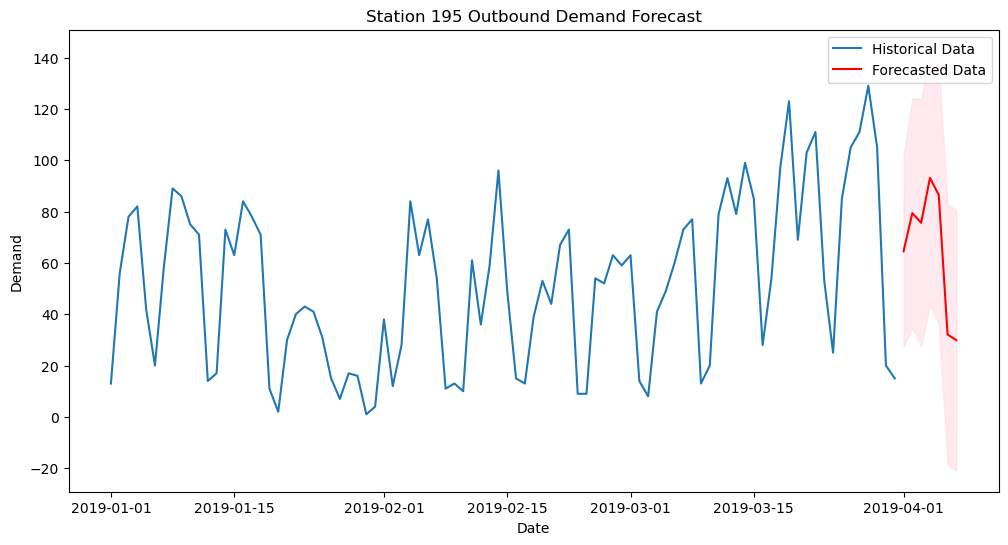

Station 195 Outbound Demand - MAE: 33.933775265116026
Station 195 Outbound Demand - RMSE: 40.13404430634481
Inbound Demand Analysis and Forecast:
Station 195 Inbound Demand - ADF Statistic: -1.2657096147279987
Station 195 Inbound Demand - p-value: 0.6447106142797263
Station 195 Inbound Demand - Best ARIMA Model:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 7)   Log Likelihood                -357.118
Date:                            Wed, 30 Oct 2024   AIC                            724.237
Time:                                    10:18:59   BIC                            736.680
Sample:                                01-01-2019   HQIC                           729.252
                                     - 03-31-2019                                         
Covariance Type:                              opg

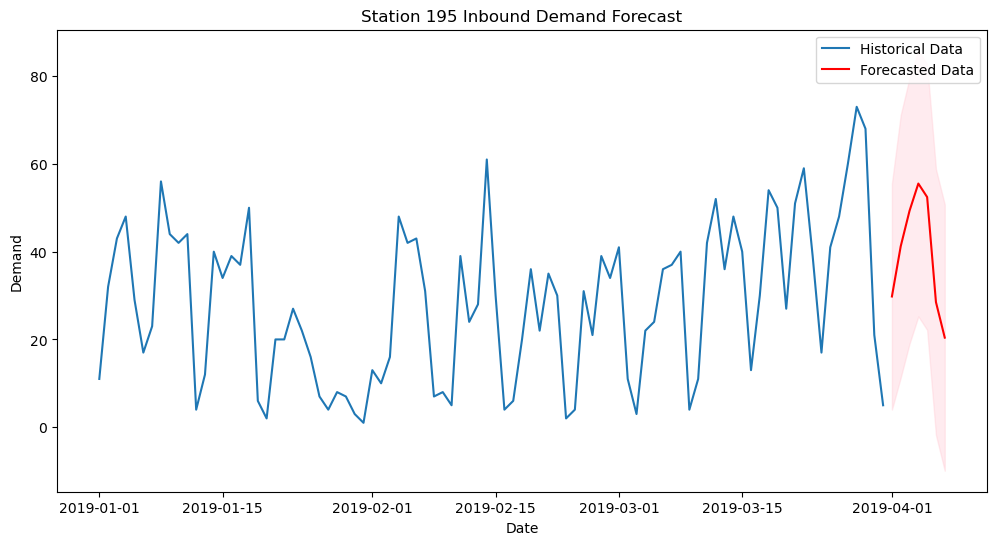

Station 195 Inbound Demand - MAE: 18.417542180965334
Station 195 Inbound Demand - RMSE: 22.35024554045582


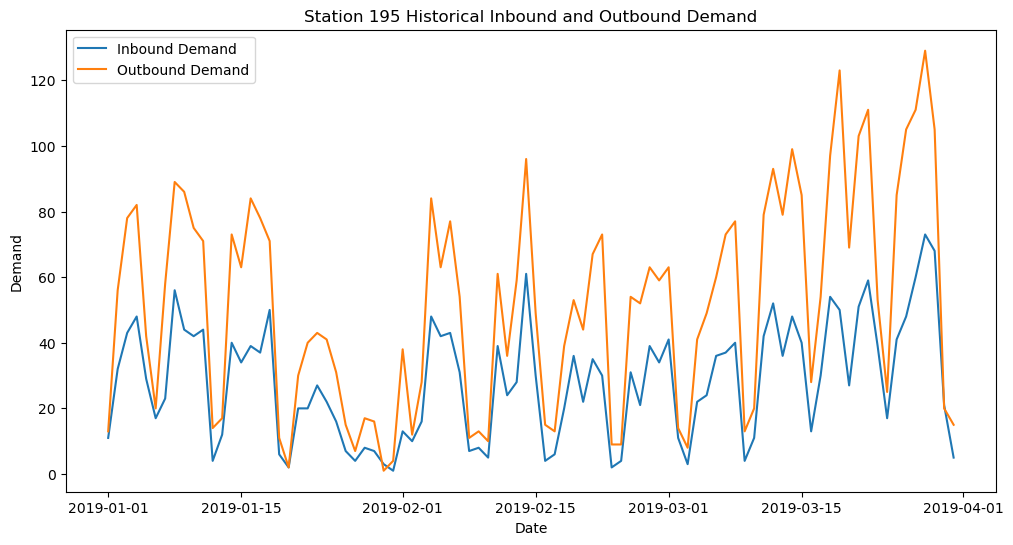

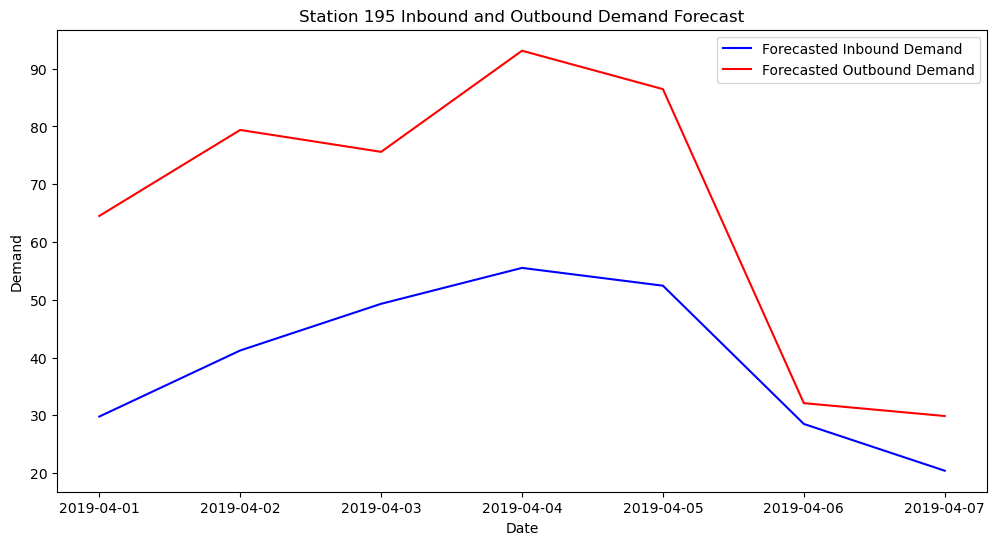

In [9]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Load data
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')

# 2. Convert time format and extract dates
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date

# Choose the station to analyze (e.g., station ID 195)
station_id = 195

# 3. Build outbound time series
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
outbound_series = outbound_data.asfreq('D', fill_value=0)

# 4. Build inbound time series
inbound_data = df[df['to_station_id'] == station_id].groupby('end_date').size()
inbound_series = inbound_data.asfreq('D', fill_value=0)

# 5. Define a function for time series analysis and forecasting
def analyze_and_forecast(time_series, title):
    # Check time series stationarity (ADF test)
    result = adfuller(time_series)
    print(f'{title} - ADF Statistic: {result[0]}')
    print(f'{title} - p-value: {result[1]}')
    # If p-value > 0.05, the series is non-stationary and differencing may be needed

    # Automatically select ARIMA model parameters
    auto_arima_model = auto_arima(time_series, seasonal=True, m=7, trace=False)  # Using seasonal=True and m=7 for weekly seasonality
    print(f'{title} - Best ARIMA Model:')
    print(auto_arima_model.summary())

    # Fit ARIMA model
    order = auto_arima_model.order
    seasonal_order = auto_arima_model.seasonal_order
    model = ARIMA(time_series, order=order, seasonal_order=seasonal_order)
    arima_result = model.fit()

    # Forecast future demand (e.g., next 7 days)
    forecast_steps = 7
    forecast = arima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label='Historical Data')
    plt.plot(forecast_series, label='Forecasted Data', color='red')
    plt.fill_between(forecast_series.index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'{title} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

    # Calculate error metrics
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]
    model_train = ARIMA(train, order=order, seasonal_order=seasonal_order).fit()
    pred_test = model_train.forecast(len(test))
    mae = mean_absolute_error(test, pred_test)
    rmse = np.sqrt(mean_squared_error(test, pred_test))
    print(f'{title} - MAE: {mae}')
    print(f'{title} - RMSE: {rmse}')

    return forecast_series

# 6. Analyze and forecast outbound demand
print('Outbound Demand Analysis and Forecast:')
forecast_outbound = analyze_and_forecast(outbound_series, f'Station {station_id} Outbound Demand')

# 7. Analyze and forecast inbound demand
print('Inbound Demand Analysis and Forecast:')
forecast_inbound = analyze_and_forecast(inbound_series, f'Station {station_id} Inbound Demand')

# 8. Visualize historical inbound and outbound data
plt.figure(figsize=(12, 6))
plt.plot(inbound_series.index, inbound_series, label='Inbound Demand')
plt.plot(outbound_series.index, outbound_series, label='Outbound Demand')
plt.title(f'Station {station_id} Historical Inbound and Outbound Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

# 9. Visualize forecasted inbound and outbound demand
plt.figure(figsize=(12, 6))
plt.plot(forecast_inbound.index, forecast_inbound, label='Forecasted Inbound Demand', color='blue')
plt.plot(forecast_outbound.index, forecast_outbound, label='Forecasted Outbound Demand', color='red')
plt.title(f'Station {station_id} Inbound and Outbound Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()


24h

Single-Day Outbound Forecast:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=11.64 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=8905.273, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=8304.695, Time=1.01 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=8269.604, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=8903.273, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=8641.147, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=10.56 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=8145.816, Time=7.46 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=31.99 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=8604.387, Time=4.80 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=inf, Time=33.60 sec
 ARIMA(0,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=23.84 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=8336.821, Time=5.50 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=51.75 sec
 ARIMA(0,1,1)

 This problem is unconstrained.



At iterate    5    f=  1.88330D+00    |proj g|=  3.04911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   6.586D-07   1.883D+00
  F =   1.8832908152200949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


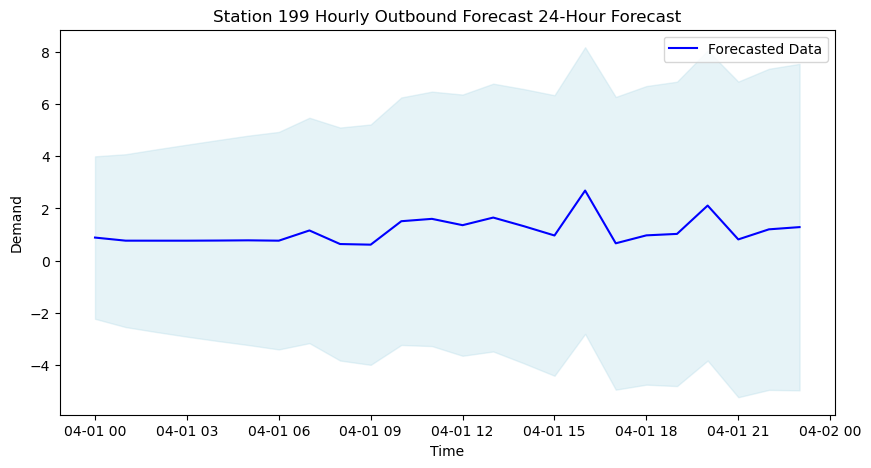

Single-Day Inbound Forecast:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=14.97 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=8910.882, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=8374.868, Time=1.14 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=8012.321, Time=5.16 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=8908.882, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=8301.703, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=8.12 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=7951.663, Time=25.15 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=46.68 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=8786.734, Time=9.71 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=inf, Time=41.33 sec
 ARIMA(0,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=52.56 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=8388.785, Time=10.97 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=68.43 sec
 ARIMA(0,1,1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89857D+00    |proj g|=  9.58149D-02

At iterate    5    f=  1.85272D+00    |proj g|=  1.29891D-02

At iterate   10    f=  1.84993D+00    |proj g|=  1.83470D-03

At iterate   15    f=  1.84950D+00    |proj g|=  1.33660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   2.918D-06   1.850D+00
  F =   1.8495030271743160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


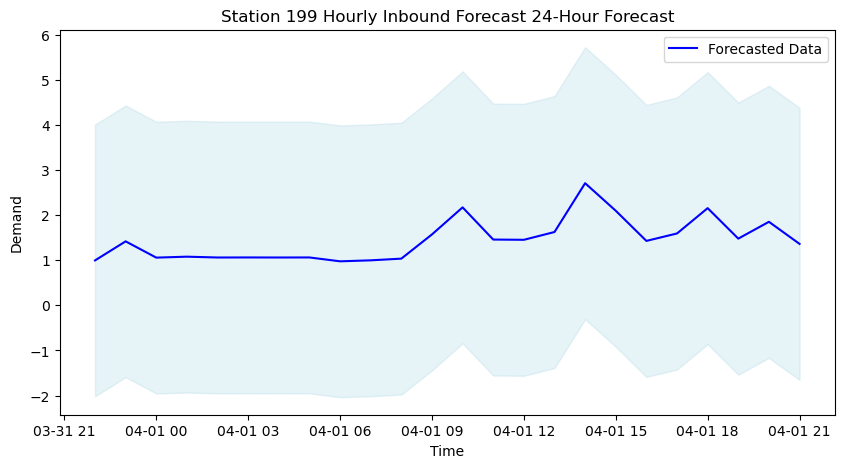

In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')

# 2. Convert times to hourly timestamps
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_hour'] = df['start_time'].dt.floor('H')
df['end_hour'] = df['end_time'].dt.floor('H')

# 3. Select the station ID to analyze
station_id = 199  # Example station ID

# 4. Calculate hourly outbound and inbound counts
outbound_data = df[df['from_station_id'] == station_id].groupby('start_hour').size()
inbound_data = df[df['to_station_id'] == station_id].groupby('end_hour').size()

# Fill missing hourly data with 0 and set to hourly frequency
outbound_series = outbound_data.asfreq('H', fill_value=0)
inbound_series = inbound_data.asfreq('H', fill_value=0)

# 5. Analysis and forecasting function (modified for single-day forecast plot)
def forecast_single_day(time_series, title):
    # Automatically select SARIMA model parameters
    auto_arima_model = auto_arima(time_series, seasonal=True, m=24, trace=True)
    print(f'{title} Best SARIMA Model Parameters:', auto_arima_model.order, auto_arima_model.seasonal_order)

    # Fit SARIMA model
    order = auto_arima_model.order
    seasonal_order = auto_arima_model.seasonal_order
    model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    sarima_result = model.fit()

    # Forecast demand for the next 24 hours
    forecast_steps = 24
    forecast = sarima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

    # Plot only the forecasted data
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_series, label='Forecasted Data', color='blue')
    plt.fill_between(forecast_series.index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='lightblue', alpha=0.3)
    plt.title(f'{title} 24-Hour Forecast')
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

# 6. Forecast single-day outbound count
print('Single-Day Outbound Forecast:')
forecast_single_day(outbound_series, f'Station {station_id} Hourly Outbound Forecast')

# 7. Forecast single-day inbound count
print('Single-Day Inbound Forecast:')
forecast_single_day(inbound_series, f'Station {station_id} Hourly Inbound Forecast')
